In [1]:
# To run this notebook, make sure you have scikit-learn, pandas and numpy installed. The file "latestdata.csv"
# containing the dataset should also be in the same directory as the working directory of Jupyter in order for it to
# load the file.

import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder

pd.set_option("display.max_columns", 50)

In [2]:
data = pd.read_csv("latestdata.csv", low_memory=False)

In [3]:
data

,ID,age,sex,city,province,country,latitude,longitude,geo_resolution,date_onset_symptoms,date_admission_hospital,date_confirmation,symptoms,lives_in_Wuhan,travel_history_dates,travel_history_location,reported_market_exposure,additional_information,chronic_disease_binary,chronic_disease,source,sequence_available,outcome,date_death_or_discharge,notes_for_discussion,location,admin3,admin2,admin1,country_new,admin_id,data_moderator_initials,travel_history_binary
0,000-1-1,NaN,male,Shek Lei,Hong Kong,China,22.365019,114.133808,point,NaN,NaN,14.02.2020,NaN,NaN,22.01.2020,China,NaN,Case 55; mainland China travel via the Lok Ma ...,False,NaN,https://www.scmp.com/news/hong-kong/health-env...,NaN,"critical condition, intubated as of 14.02.2020",NaN,NaN,Shek Lei,NaN,NaN,Hong Kong,China,8029.0,NaN,NaN
1,000-1-10,78,male,Vo Euganeo,Veneto,Italy,45.297748,11.658382,point,NaN,NaN,21.02.2020,NaN,NaN,NaN,NaN,NaN,Hospitalized on 12.02.2020 for other reasons,False,NaN,https://www.corriere.it/cronache/20_febbraio_2...,NaN,death,22.02.2020,NaN,Vo' Euganeo,NaN,NaN,Veneto,Italy,8954.0,NaN,NaN
2,000-1-100,61,female,NaN,NaN,Singapore,1.353460,103.815100,admin0,NaN,NaN,14.02.2020,NaN,NaN,NaN,NaN,NaN,"Case 65; family member of Case 50, a DBS emplo...",False,NaN,https://www.channelnewsasia.com/news/singapore...,NaN,discharge,17.02.2020,NaN,NaN,NaN,NaN,NaN,Singapore,200.0,NaN,NaN
3,000-1-1000,NaN,NaN,Zhengzhou City,Henan,China,34.629310,113.468000,admin2,NaN,NaN,26.01.2020,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN,https://news.163.com/special/epidemic/?spssid=...,NaN,NaN,NaN,NaN,NaN,NaN,Zhengzhou City,Henan,China,10091.0,NaN,NaN
4,000-1-10000,NaN,NaN,Pingxiang City,Jiangxi,China,27.513560,113.902900,admin2,NaN,NaN,14.02.2020,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN,http://hc.jiangxi.gov.cn/doc/2020/02/15/138898...,NaN,NaN,NaN,NaN,NaN,NaN,Pingxiang City,Jiangxi,China,7060.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2676306,010-99995,52,female,Calleria,Coronel Portillo,Peru,-8.378190,-74.539700,point,NaN,NaN,17.05.2020,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Peru,14429.0,NaN,False
2676307,010-99996,52,female,Pueblo Libre,Lima,Peru,-12.076530,-77.067350,point,NaN,NaN,17.05.2020,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Peru,14695.0,NaN,False
2676308,010-99997,52,female,Comas,Lima,Peru,-11.932980,-77.040850,point,NaN,NaN,17.05.2020,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Peru,14400.0,NaN,False
2676309,010-99998,52,male,Callao,Callao,Peru,-12.000740,-77.118240,point,NaN,NaN,17.05.2020,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Peru,14516.0,NaN,False


In [4]:
data.isna().sum() # Print how many fields have missing data

ID                                0
age                         2098293
sex                         2096154
city                         977681
province                     452664
country                         115
latitude                         61
longitude                        61
geo_resolution                   61
date_onset_symptoms         2414712
date_admission_hospital     2560100
date_confirmation            108489
symptoms                    2674259
lives_in_Wuhan              2671973
travel_history_dates        2673700
travel_history_location     2667089
reported_market_exposure    2675242
additional_information      2630456
chronic_disease_binary            0
chronic_disease             2676096
source                       566964
sequence_available          2676299
outcome                     2368929
date_death_or_discharge     2673163
notes_for_discussion        2675671
location                    2662935
admin3                      2595877
admin2                      

In [5]:
# Drop categorical city/province since they encode information that already exists in longitude/latitude and have too many possible values to OneHotEncode
# There are also far too many possible values to use one-hot encoding, and label encoding is nonsensical as the data is not ordinal
data = data.drop(["city", "province", "country_new", "admin1", "admin2", "admin3", "location"], axis=1)

# Drop ID, admin_id, data_moderator_initials, source since they encode nothing about the case
data = data.drop(["ID","admin_id","data_moderator_initials", "source", "geo_resolution"], axis=1)

# Drop additional_information, notes_for_discussion for much the same reason
data = data.drop(["additional_information", "notes_for_discussion", "sequence_available", "travel_history_location"], axis=1)

# Drop date_death_or_discharge since it represents something we'd only know given the outcome
data = data.drop(["date_death_or_discharge"], axis=1)

In [6]:
data.dtypes

age                          object
sex                          object
country                      object
latitude                    float64
longitude                   float64
date_onset_symptoms          object
date_admission_hospital      object
date_confirmation            object
symptoms                     object
lives_in_Wuhan               object
travel_history_dates         object
reported_market_exposure     object
chronic_disease_binary         bool
chronic_disease              object
outcome                      object
travel_history_binary        object
dtype: object

In [7]:
# Next we need to start preparing some of this data to be useful. Age (at the minute) can be encoded as an exact value, be absent, or be in any number of ranges
# I will define a function to take an age range, transform it into an integer, then bin it into 10-year age categories which will be then encoded using label encoding

def map_age(age):
    age = str(age)
    if age == "nan":
        return None
    if "+" in age or age[-1] == "-":
        age = age[:2] + "-" + "100"
    if "-" in age:
        a1, a2 = age.split("-")
        age = str((int(a1)+int(a2))//2)
        if (float(age) < 1):
            age = "0"
    if len(age) == 1:
        return age
    return age[:-1]


data["age"] = data["age"].map(map_age)
    

In [8]:
map_outcome = {
    "Alive": 0,
    "Critical condition": 0, 
    "Dead": 1,
    "Death": 1,
    "Deceased": 1,
    "Died": 1,
    "Discharged": 0,
    "Discharged from hospital": 0,
    "Hospitalized": 0,
    "Migrated": 0, 
    "Migrated_Other": 0,
    "Receiving Treatment": 0,
    "Recovered": 0,
    "Stable": 0,
    "Symptoms only improved with cough. Currently hospitalized for follow-up.": 0,
    "Under treatment": 0,
    "critical condition": 0,
    "critical condition, intubated as of 14.02.2020": 0,
    "dead": 1,
    "death": 1,
    "died": 1,
    "discharge": 0,
    "discharged": 0,
    "https://www.mspbs.gov.py/covid-19.php": 0,
    "not hospitalised": 0,
    "recovered": 0,
    "recovering at home 03.03.2020" : 0,
    "released from quarantine": 0,
    "severe": 0,
    "severe illness": 0,
    "stable": 0,
    "stable condition": 0,
    "treated in an intensive care unit (14.02.2020)": 0,
    "unstable": 0
}
    
data["outcome"] = data["outcome"].map(map_outcome)

# Since we are trying to predict the "outcome" column, there's no point holding onto rows that do not have outcome defined

data.dropna(axis=0, subset=["outcome"], inplace=True)

data

,age,sex,country,latitude,longitude,date_onset_symptoms,date_admission_hospital,date_confirmation,symptoms,lives_in_Wuhan,travel_history_dates,reported_market_exposure,chronic_disease_binary,chronic_disease,outcome,travel_history_binary
0,None,male,China,22.365019,114.133808,NaN,NaN,14.02.2020,NaN,NaN,22.01.2020,NaN,False,NaN,0.0,NaN
1,7,male,Italy,45.297748,11.658382,NaN,NaN,21.02.2020,NaN,NaN,NaN,NaN,False,NaN,1.0,NaN
2,6,female,Singapore,1.353460,103.815100,NaN,NaN,14.02.2020,NaN,NaN,NaN,NaN,False,NaN,0.0,NaN
113,2,male,Singapore,1.353460,103.815100,NaN,NaN,14.02.2020,NaN,NaN,NaN,NaN,False,NaN,0.0,NaN
224,5,female,Singapore,1.353460,103.815100,NaN,NaN,14.02.2020,NaN,NaN,NaN,NaN,False,NaN,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
670224,9,female,United States,44.461123,-73.081581,NaN,NaN,18.03.2020,NaN,NaN,NaN,NaN,False,NaN,1.0,False
672529,6,male,United States,44.003584,-102.826120,NaN,NaN,10.03.2020,NaN,NaN,NaN,NaN,False,NaN,1.0,False
672651,9,female,United States,47.491332,-121.803640,NaN,NaN,04.03.2020,NaN,NaN,NaN,NaN,False,NaN,1.0,False
672674,7,male,United States,45.546910,-122.414900,NaN,NaN,10.03.2020,NaN,NaN,NaN,NaN,False,NaN,1.0,False


In [9]:
# Maps countries to world bank regions
map_country = {
    "China": "East Asia-Pacific",
    "Italy": "Europe-Central Asia",
    "Singapore": "East Asia-Pacific",
    "South Korea": "East Asia-Pacific",
    "Switzerland": "Europe-Central Asia",
    "San Marino": "Europe-Central Asia",
    "Australia": "East Asia-Pacific",
    "Japan": "East Asia-Pacific",
    "Nepal": "South Asia",
    "Malaysia": "East Asia-Pacific",
    "Thailand": "East Asia-Pacific",
    "Canada": "North America",
    "Germany": "Europe-Central Asia",
    "Philippines": "East Asia-Pacific",
    "France": "Europe-Central Asia",
    "United States": "North America",
    "Guyana": "Latin America-Caribbean",
    "Egypt": "MENA",
    "Brazil": "Latin America-Caribbean",
    "Vietnam": "East Asia-Pacific",
    "United Arab Emirates": "MENA",
    "Spain": "Europe-Central Asia",
    "Iran": "MENA",
    "Niger": "Sub-Saharan Africa",
    "Gambia": "Sub-Saharan Africa",
    "Zimbabwe": "Sub-Saharan Africa",
    "Angola": "Sub-Saharan Africa",
    "Burkina Faso": "Sub-Saharan Africa",
    "Cabo Verde": "Sub-Saharan Africa",
    "Cameroon": "Sub-Saharan Africa",
    "Central African Republic": "Sub-Saharan Africa",
    "Djibouti": "Sub-Saharan Africa",
    "Algeria": "MENA",
    "Eritrea": "Sub-Saharan Africa",
    "Eswatini": "Sub-Saharan Africa",
    "Ethiopia": "Sub-Saharan Africa",
    "Gabon": "Sub-Saharan Africa",
    "Guinea-Bissau": "Sub-Saharan Africa",
    "Guinea": "Sub-Saharan Africa",
    "Mozambique": "Sub-Saharan Africa",
    "Sudan": "Sub-Saharan Africa",
    "Tanzania": "Sub-Saharan Africa",
    "Togo": "Sub-Saharan Africa",
    "Zambia": "Sub-Saharan Africa",
    "Ghana": "Sub-Saharan Africa",
    "Kenya": "Sub-Saharan Africa",
    "Nigeria": "Sub-Saharan Africa",
    "India": "South Asia",
    "Romania": "Europe-Central Asia",
    "Bahamas": "Latin America-Caribbean",
    "Paraguay": "Latin America-Caribbean",
    "Cuba": "Latin America-Caribbean"
}

# Removes NaN countries and maps all other countries to regions
data.dropna(axis=0, subset=["country"], inplace=True)
data["region"] = data["country"].map(map_country)
data = data.drop(["country"], axis=1)

# Encodes the regions using one-hot encoding
OH_region_encoder = OneHotEncoder(handle_unknown="ignore", sparse=False)
regions_encoded = OH_region_encoder.fit_transform(data["region"].values.reshape(-1, 1))
data_encoded = pd.DataFrame(regions_encoded, columns=OH_region_encoder.get_feature_names(), index=data.index)
data = pd.concat([data, data_encoded], axis=1)
data = data.drop(["region"], axis=1)

In [10]:
# Take a look at what we have left to see what we can do
data.isna().sum()

age                           272947
sex                           269267
latitude                           0
longitude                          0
date_onset_symptoms           303837
date_admission_hospital       307079
date_confirmation                 74
symptoms                      306904
lives_in_Wuhan                307204
travel_history_dates          307063
reported_market_exposure      307362
chronic_disease_binary             0
chronic_disease               307255
outcome                            0
travel_history_binary            323
x0_East Asia-Pacific               0
x0_Europe-Central Asia             0
x0_Latin America-Caribbean         0
x0_MENA                            0
x0_North America                   0
x0_South Asia                      0
x0_Sub-Saharan Africa              0
dtype: int64

In [11]:
# Let's work on getting dates processed

import datetime, math

data.dropna(axis=0, subset=["date_confirmation"], inplace=True)

def parse_date(date):
    if "-" in date:
        dates = date.replace(" ", "").split("-")
        if dates[0] == "":
            d1, m1, y1 = dates[1].split(".")
            return datetime.date(int(y1), int(m1), int(d1))
        elif dates[1] == "":
            d1, m1, y1 = dates[0].split(".")
            return datetime.date(int(y1), int(m1), int(d1))
        d1, m1, y1 = dates[0].split(".")
        d2, m2, y2 = dates[1].split(".")
        range_start = datetime.date(int(y1), int(m1), int(d1))
        range_end = datetime.date(int(y2), int(m2), int(d2))
        delta = range_end - range_start
        return range_start + delta*0.5     
    else:
        d_conf, m_conf, y_conf = date.split(".")
        return datetime.date(int(y_conf), int(m_conf), int(d_conf))

def process_dates(row):
    date_confirmation = parse_date(row["date_confirmation"])
    if (not isinstance(row["date_onset_symptoms"], float) or not math.isnan(row["date_onset_symptoms"])) and (not isinstance(row["date_admission_hospital"], float) or not math.isnan(row["date_admission_hospital"])):
        date_onset = parse_date(row["date_onset_symptoms"])
        row["date_onset_symptoms"] = (date_onset - date_confirmation).days
        date_admission = parse_date(row["date_admission_hospital"])
        row["date_admission_hospital"] = (date_admission - date_confirmation).days
    elif not isinstance(row["date_onset_symptoms"], float) or not math.isnan(row["date_onset_symptoms"]):
        date_onset = parse_date(row["date_onset_symptoms"])
        row["date_onset_symptoms"] = (date_onset - date_confirmation).days
        row["date_confirmation"] = float("nan")
    elif not isinstance(row["date_admission_hospital"], float) or not math.isnan(row["date_admission_hospital"]):
        date_admission = parse_date(row["date_admission_hospital"])
        row["date_admission_hospital"] = (date_admission - date_confirmation).days
        row["date_confirmation"] = float("nan")
    else:
        row["date_confirmation"] = float("nan")
    if not isinstance(row["travel_history_dates"], float) or not math.isnan(row["travel_history_dates"]):
        date_travel = parse_date(row["travel_history_dates"])
        row["travel_history_dates"] = (date_travel - date_confirmation).days
    return row
        
data = data.apply(process_dates, axis=1)
data = data.rename({"date_onset_symptoms": "days_conf_to_symptoms", "date_admission_hospital": "days_conf_to_hospital", "travel_history_dates": "days_conf_to_travel"}, axis=1)
data = data.drop(["date_confirmation"], axis=1)

In [12]:
# Another important thing to look at is symptoms. The data is unusable right now, but what we can do is One-Hot encode
# for the most common symptoms that appear

data["symptoms"].value_counts()[0:10]

Mild to moderate                                 257
fever                                             12
acute respiratory failure:pneumonia               11
cough, fever                                      10
acute respiratory distress syndrome:pneumonia     10
septic shock:pneumonia                             7
pneumonia                                          7
acute respiratory distress syndrome                4
fever, sore throat                                 4
none                                               3
Name: symptoms, dtype: int64

In [13]:
# Encodes the most common symptoms (symptoms in the 10 most common values) with one-hot encoding
data["Mild to moderate"] = data["symptoms"].map(lambda x: 1 if not isinstance(x, float) and "Mild to moderate" in x else 0)
data["fever"] = data["symptoms"].map(lambda x: 1 if not isinstance(x, float) and "fever" in x else 0)
data["respiratory distress"] = data["symptoms"].map(lambda x: 1 if not isinstance(x, float) and "respiratory" in x else 0)
data["cough"] = data["symptoms"].map(lambda x: 1 if not isinstance(x, float) and "cough" in x else 0)
data["pneumonia"] = data["symptoms"].map(lambda x: 1 if not isinstance(x, float) and "pneumonia" in x else 0)
data["septic shock"] = data["symptoms"].map(lambda x: 1 if not isinstance(x, float) and "septic shock" in x else 0)
data["sore throat"] = data["symptoms"].map(lambda x: 1 if not isinstance(x, float) and "sore throat" in x else 0)

data["has symptoms"] = data["symptoms"].map(lambda x: 0 if isinstance(x, float) and math.isnan(x) else 1)
data = data.drop(["symptoms"], axis=1)

In [14]:
# In a similar vein, we shall try to tackle the chronic disease columns, looking at the most common values and encoding them
data["chronic_disease"].value_counts()[0:10]

hypertension                           16
hypertension:diabetes                  10
diabetes:hypertension                   6
diabetes                                5
hypertensive                            3
asthma                                  3
chronic kidney disease                  3
hypertension:chronic kidney disease     3
prostate hypertrophy                    2
HIV positive                            2
Name: chronic_disease, dtype: int64

In [15]:
# Encode all of the common chronic diseases
data["hypertension"] = data["chronic_disease"].map(lambda x: 1 if not isinstance(x, float) and ("hypertension" in x or "hypertensive" in x) else 0)
data["diabetes"] = data["chronic_disease"].map(lambda x: 1 if not isinstance(x, float) and "diabetes" in x else 0)
data["asthma"] = data["chronic_disease"].map(lambda x: 1 if not isinstance(x, float) and "asthma" in x else 0)
data["chronic kidney disease"] = data["chronic_disease"].map(lambda x: 1 if not isinstance(x, float) and "chronic kidney disease" in x else 0)
data["prostate hypertrophy"] = data["chronic_disease"].map(lambda x: 1 if not isinstance(x, float) and "prostate hypertrophy" in x else 0)
data["coronary heart disease"] = data["chronic_disease"].map(lambda x: 1 if not isinstance(x, float) and "coronary heart disease" in x else 0)
data["lung cancer"] = data["chronic_disease"].map(lambda x: 1 if not isinstance(x, float) and "lung cancer" in x else 0)

# Create new 0 or 1 chronic disease column (also groups the chronic stuff together which is good for my sanity)
data["has chronic disease"] = data["chronic_disease_binary"].map(lambda x: 1 if x else 0)
data = data.drop(["chronic_disease_binary"], axis=1)
data = data.drop(["chronic_disease"], axis=1)

In [16]:
# Map travel history binary to 0 and 1
data["travel_history_binary"] = data["travel_history_binary"].map(lambda x: 1 if x and not isinstance(x, float) else 0)
data

,age,sex,latitude,longitude,days_conf_to_symptoms,days_conf_to_hospital,lives_in_Wuhan,days_conf_to_travel,reported_market_exposure,outcome,travel_history_binary,x0_East Asia-Pacific,x0_Europe-Central Asia,x0_Latin America-Caribbean,x0_MENA,x0_North America,x0_South Asia,x0_Sub-Saharan Africa,Mild to moderate,fever,respiratory distress,cough,pneumonia,septic shock,sore throat,has symptoms,hypertension,diabetes,asthma,chronic kidney disease,prostate hypertrophy,coronary heart disease,lung cancer,has chronic disease
0,None,male,22.365019,114.133808,NaN,NaN,NaN,-23.0,NaN,0.0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,7,male,45.297748,11.658382,NaN,NaN,NaN,NaN,NaN,1.0,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,6,female,1.353460,103.815100,NaN,NaN,NaN,NaN,NaN,0.0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
113,2,male,1.353460,103.815100,NaN,NaN,NaN,NaN,NaN,0.0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
224,5,female,1.353460,103.815100,NaN,NaN,NaN,NaN,NaN,0.0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
670224,9,female,44.461123,-73.081581,NaN,NaN,NaN,NaN,NaN,1.0,0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
672529,6,male,44.003584,-102.826120,NaN,NaN,NaN,NaN,NaN,1.0,0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
672651,9,female,47.491332,-121.803640,NaN,NaN,NaN,NaN,NaN,1.0,0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
672674,7,male,45.546910,-122.414900,NaN,NaN,NaN,NaN,NaN,1.0,0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [17]:
# This column is defined for only 15 rows and all of them are in the negative, so there's no point keeping it
data["reported_market_exposure"].value_counts()

data = data.drop(["reported_market_exposure"], axis=1)

In [18]:
# Not defined for many so the "yes" responses would be a tiny class
data["lives_in_Wuhan"].value_counts()

data = data.drop(["lives_in_Wuhan"], axis=1)

In [19]:
# Now we need to take another look at what we have

data.isna().sum()

# Age - kind of a pain since imputing will wreck the distribution of the data
# Sex - Similar to age here
# days_... - In these instances we may be able to get waway with an extra variable saying whether or not they were imputed

age                           272944
sex                           269264
latitude                           0
longitude                          0
days_conf_to_symptoms         303801
days_conf_to_hospital         307044
days_conf_to_travel           306990
outcome                            0
travel_history_binary              0
x0_East Asia-Pacific               0
x0_Europe-Central Asia             0
x0_Latin America-Caribbean         0
x0_MENA                            0
x0_North America                   0
x0_South Asia                      0
x0_Sub-Saharan Africa              0
Mild to moderate                   0
fever                              0
respiratory distress               0
cough                              0
pneumonia                          0
septic shock                       0
sore throat                        0
has symptoms                       0
hypertension                       0
diabetes                           0
asthma                             0
c

In [20]:
# For now let's try just dropping the empty age/sex data
data = data.dropna(subset=["age", "sex"])
data.isna().sum()

age                               0
sex                               0
latitude                          0
longitude                         0
days_conf_to_symptoms         30034
days_conf_to_hospital         33286
days_conf_to_travel           33293
outcome                           0
travel_history_binary             0
x0_East Asia-Pacific              0
x0_Europe-Central Asia            0
x0_Latin America-Caribbean        0
x0_MENA                           0
x0_North America                  0
x0_South Asia                     0
x0_Sub-Saharan Africa             0
Mild to moderate                  0
fever                             0
respiratory distress              0
cough                             0
pneumonia                         0
septic shock                      0
sore throat                       0
has symptoms                      0
hypertension                      0
diabetes                          0
asthma                            0
chronic kidney disease      

In [21]:
# Convert male/female to int

data["sex"] = data["sex"].map(lambda x: 1 if x == "male" else 0)

In [22]:
# Let's also scale everything between 0 and 1 whilst we're at it

from sklearn.preprocessing import MinMaxScaler

min_max_scaler = MinMaxScaler()

data = pd.DataFrame(min_max_scaler.fit_transform(data), columns=data.columns, index=data.index)
data

,age,sex,latitude,longitude,days_conf_to_symptoms,days_conf_to_hospital,days_conf_to_travel,outcome,travel_history_binary,x0_East Asia-Pacific,x0_Europe-Central Asia,x0_Latin America-Caribbean,x0_MENA,x0_North America,x0_South Asia,x0_Sub-Saharan Africa,Mild to moderate,fever,respiratory distress,cough,pneumonia,septic shock,sore throat,has symptoms,hypertension,diabetes,asthma,chronic kidney disease,prostate hypertrophy,coronary heart disease,lung cancer,has chronic disease
1,0.129630,1.0,0.953049,0.487372,NaN,NaN,NaN,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.111111,0.0,0.431015,0.820669,NaN,NaN,NaN,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
113,0.037037,1.0,0.431015,0.820669,NaN,NaN,NaN,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
224,0.092593,0.0,0.431015,0.820669,NaN,NaN,NaN,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
335,0.129630,0.0,0.431020,0.820834,0.548387,NaN,NaN,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
670224,0.166667,0.0,0.943111,0.180898,NaN,NaN,NaN,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
672529,0.111111,1.0,0.937675,0.073323,NaN,NaN,NaN,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
672651,0.166667,0.0,0.979108,0.004688,NaN,NaN,NaN,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
672674,0.129630,1.0,0.956009,0.002478,NaN,NaN,NaN,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [23]:
data["outcome"].value_counts()

0.0    32201
1.0     1326
Name: outcome, dtype: int64

In [24]:
# Let's try some machine learning

In [25]:
# Now we need to format the data in such a way that sklearn can deal with it

from sklearn.model_selection import train_test_split

y = data["outcome"]
X = data.drop(["outcome"], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
X_train = X_train.copy()
X_test = X_test.copy()

In [26]:
# Ok what we're actually going to do is ignore the previous stuff and try using cross_val_score

for col in ["days_conf_to_symptoms", "days_conf_to_hospital", "days_conf_to_travel"]:
    X_train[col + "_imputed"] = X_train[col].map(lambda x: 1 if math.isnan(x) else 0)
    X_train[col].fillna(X_train[col].mean(), inplace=True)
    X_test[col + "_imputed"] = X_test[col].map(lambda x: 1 if math.isnan(x) else 0)
    X_test[col].fillna(X_test[col].mean(), inplace=True)

In [27]:
# Machine learning?

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import roc_curve, auc, roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt

In [28]:
# Plotting and scoring functions

def score_auc(estimator, X, y):
    yp = estimator.predict_proba(X)[:, 1]
    score = roc_auc_score(y, yp)
    return score

def plot_roc(y, yp_score):
    fpr, tpr, _ = roc_curve(y, yp_score)
    plot_curve(fpr, tpr)
    
def plot_curve(tpr, fpr, title="ROC", x_label="FPR", y_label="TPR", legend_loc="lower right", curve_type="ROC"):
    roc_auc = auc(fpr, tpr)
    
    plt.figure()
    plt.plot(fpr, tpr, label=curve_type + "  curve (area = %0.2f)" % roc_auc)
    plt.plot([0,1], [0,1], "k--")
    plt.xlim([0.0,1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)
    plt.legend(loc=legend_loc)
    plt.show()
    
def plot_many(tprs, fpr, title="ROC", x_label="FPR", y_label="TPR", legend_loc="lower right", curve_type="ROC"):
    plt.figure()
    for i in range(len(tprs)):
        roc_auc = auc(fpr, tprs[i])
        plt.plot(fpr, tprs[i], "--", label="ROC curve - fold " + str(i) + "(area = %0.2f)" % roc_auc)
        
    final_tpr = []
    for i in range(len(tprs[0])):
        total = 0
        for j in range(len(tprs)):
            total += tprs[j][i]
        final_tpr.append(total/len(tprs))
    final_aoc = auc(fpr, final_tpr)
    plt.plot(fpr, final_tpr, label="Mean " + curve_type +" curve (area = %0.2f)" % final_aoc, lw=3)
    plt.plot([0,1], [0,1], "k--")
    plt.xlim([0.0,1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)
    plt.legend(loc=legend_loc)
    plt.show()

In [29]:
# Tunes hyperparameters for the random forest model

from sklearn.ensemble import RandomForestClassifier

min_samples_leaf = range(1,5)
max_features = ["sqrt", "log2"]
criterion = ["gini", "entropy"]
max_depth = list(range(7,12)) + [None]
min_samples_split = range(2,5) # Hyperparameters to tweak

hp_combs = [[msl, mf, c, md, mss] for msl in min_samples_leaf for mf in max_features for c in criterion for md in max_depth for mss in min_samples_split]

results = []
scv = StratifiedKFold()

for comb in hp_combs:
    clf = RandomForestClassifier(class_weight="balanced", n_jobs=-1, min_samples_leaf=comb[0], max_features=comb[1], criterion=comb[2], max_depth=comb[3], min_samples_split=comb[4], random_state=0)
    score = cross_val_score(clf, X_train, y_train, cv=scv, scoring=score_auc, n_jobs=5)
    results.append([comb, score.mean()])
    
best_forest = max(results, key=lambda x: x[1])
comb_forest = best_forest[0]
comb_forest

[1, 'sqrt', 'gini', 9, 4]

[[5836, 48], [596, 226]]
Acc: 0.9039665970772442 
FPR: 0.09266169154228855 
FNR: 0.17518248175182483 
PPV: 0.2749391727493917 
NPV: 0.9918422841604351 
Recall: 0.8248175182481752 
Precision: 0.2749391727493917 
F1: 0.4124087591240876 
F0.5: 0.31723750701852893 
Specificity: 0.9073383084577115


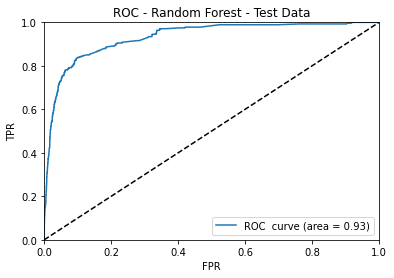

In [47]:
# Trains random forest on whole dataset and calculates metrics

clf = RandomForestClassifier(class_weight="balanced", n_jobs=-1, min_samples_leaf=comb_forest[0], max_features=comb_forest[1], criterion=comb_forest[2], max_depth=comb_forest[3], min_samples_split=comb_forest[4], random_state=0)
clf.fit(X_train, y_train)
yp_score = clf.predict_proba(X_test)[:, 1]
clf_fpr, clf_tpr, _ = roc_curve(y_test, yp_score)
yp_abs = clf.predict(X_test)

mat = confusion_matrix(y_test, yp_abs, labels=[0,1])
mat = [[mat[0][0], mat[1][0]], [mat[0][1], mat[1][1]]] # Rearrange the matrix - I made a mistake here and this is the easiest correction
tot = sum(mat[0]) + sum(mat[1])
print(mat)
precision=mat[1][1]/sum(mat[1])
recall=mat[1][1]/(mat[0][1]+mat[1][1])
print("Acc:", (mat[0][0]+mat[1][1])/tot, "\nFPR:", mat[1][0]/(mat[0][0]+mat[1][0]), "\nFNR:", mat[0][1]/(mat[0][1]+mat[1][1]), "\nPPV:", precision, "\nNPV:", mat[0][0]/sum(mat[0]), "\nRecall:", recall, "\nPrecision:", precision, "\nF1:", 2*(precision*recall)/(precision+recall), "\nF0.5:", 1.25*(precision*recall)/(0.25*precision+recall), "\nSpecificity:", mat[0][0]/(mat[0][0]+mat[1][0]))

plot_curve(clf_tpr, clf_fpr, title="ROC - Random Forest - Test Data")

In [36]:
# Tunes hyperparameter for logistic regression

from sklearn.linear_model import LogisticRegression

regularisers = ["none", "l1", "l2", "elasticnet"]

results = []

scv = StratifiedKFold()
for r in regularisers:
    lrc = LogisticRegression(class_weight="balanced", max_iter=1200, penalty=r, random_state=0)
    score = cross_val_score(lrc, X_train, y_train, cv=scv, scoring=score_auc, n_jobs=5)
    results.append([r, score.mean()])
    
best_lrc = max(results, key=lambda x: x[1])
lrc_r = best_lrc[0]
lrc_r

'l2'

[[5509, 57], [923, 217]]
Acc: 0.8538622129436325 
FPR: 0.14350124378109452 
FNR: 0.20802919708029197 
PPV: 0.19035087719298247 
NPV: 0.9897592526051024 
Recall: 0.791970802919708 
Precision: 0.19035087719298247 
F1: 0.3069306930693069 
F0.5: 0.2244517997517584 
Specificity: 0.8564987562189055


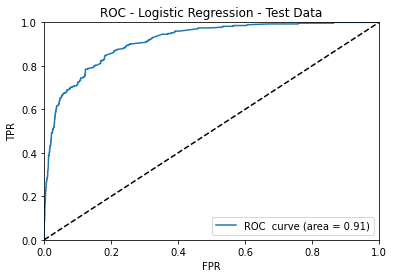

In [48]:
# Trains on whole dataset and calculates metrics

lrc = LogisticRegression(class_weight="balanced", max_iter=1200, penalty=lrc_r, random_state=0)
lrc.fit(X_train, y_train)
yp_score = lrc.predict_proba(X_test)[:, 1]
lrc_fpr, lrc_tpr, _ = roc_curve(y_test, yp_score)
yp_abs = lrc.predict(X_test)

mat = confusion_matrix(y_test, yp_abs, labels=[0,1])
mat = [[mat[0][0], mat[1][0]], [mat[0][1], mat[1][1]]] # Rearrange the matrix - I made a mistake here and this is the easiest correction
tot = sum(mat[0]) + sum(mat[1])
print(mat)
precision=mat[1][1]/sum(mat[1])
recall=mat[1][1]/(mat[0][1]+mat[1][1])
print("Acc:", (mat[0][0]+mat[1][1])/tot, "\nFPR:", mat[1][0]/(mat[0][0]+mat[1][0]), "\nFNR:", mat[0][1]/(mat[0][1]+mat[1][1]), "\nPPV:", precision, "\nNPV:", mat[0][0]/sum(mat[0]), "\nRecall:", recall, "\nPrecision:", precision, "\nF1:", 2*(precision*recall)/(precision+recall), "\nF0.5:", 1.25*(precision*recall)/(0.25*precision+recall), "\nSpecificity:", mat[0][0]/(mat[0][0]+mat[1][0]))

plot_curve(lrc_tpr, lrc_fpr, title="ROC - Logistic Regression - Test Data")

In [33]:
# Let's just have a go at k-nearest neighbours

from sklearn.neighbors import KNeighborsClassifier

k = range(28,32) # This is a small range - I previously ran it with more options, but this takes forever which I didn't
# want to deal with every time I ran it
weights = ["uniform", "distance"]
p = range(1,3)

hp_combs = [[k1, w, p1] for k1 in k for w in weights for p1 in p]

results = []

scv = StratifiedKFold()
for comb in hp_combs:
    knn = KNeighborsClassifier(n_neighbors=comb[0], weights=comb[1], p=comb[2], n_jobs=-1)
    score = cross_val_score(knn, X_train, y_train, cv=scv, scoring=score_auc, n_jobs=-1)
    results.append([comb, score.mean()])
    
best_knn = max(results, key=lambda x: x[1])
comb_knn = best_knn[0]
comb_knn

[31, 'uniform', 1]

[[6411, 218], [21, 56]]
Acc: 0.9643602743811512 
FPR: 0.0032649253731343282 
FNR: 0.7956204379562044 
PPV: 0.7272727272727273 
NPV: 0.9671141952028963 
Recall: 0.20437956204379562 
Precision: 0.7272727272727273 
F1: 0.3190883190883191 
F0.5: 0.4810996563573883 
Specificity: 0.9967350746268657


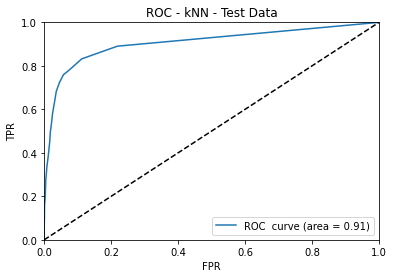

In [49]:
# Trains and evaluates knn model

knn = KNeighborsClassifier(n_neighbors=comb_knn[0], weights=comb_knn[1], p=comb_knn[2], n_jobs=-1)
knn.fit(X_train, y_train)
yp_score = knn.predict_proba(X_test)[:, 1]
knn_fpr, knn_tpr, _ = roc_curve(y_test, yp_score)
yp_abs = knn.predict(X_test)

mat = confusion_matrix(y_test, yp_abs, labels=[0,1])
mat = [[mat[0][0], mat[1][0]], [mat[0][1], mat[1][1]]] # Rearrange the matrix - I made a mistake here and this is the easiest correction
tot = sum(mat[0]) + sum(mat[1])
print(mat)
precision=mat[1][1]/sum(mat[1])
recall=mat[1][1]/(mat[0][1]+mat[1][1])
print("Acc:", (mat[0][0]+mat[1][1])/tot, "\nFPR:", mat[1][0]/(mat[0][0]+mat[1][0]), "\nFNR:", mat[0][1]/(mat[0][1]+mat[1][1]), "\nPPV:", precision, "\nNPV:", mat[0][0]/sum(mat[0]), "\nRecall:", recall, "\nPrecision:", precision, "\nF1:", 2*(precision*recall)/(precision+recall), "\nF0.5:", 1.25*(precision*recall)/(0.25*precision+recall), "\nSpecificity:", mat[0][0]/(mat[0][0]+mat[1][0]))

plot_curve(knn_tpr, knn_fpr, title="ROC - kNN - Test Data")

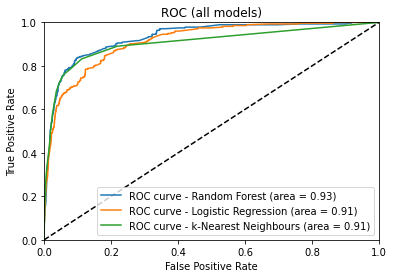

In [38]:
# Plots all curves on the same axis

def plot_all_roc(tprs, fprs, title, legend):
    plt.figure()    
    for i in range(len(tprs)):
        roc_auc = auc(fprs[i], tprs[i])
        plt.plot(fprs[i], tprs[i], label= "ROC curve - " + legend[i] + " (area = %0.2f)" % roc_auc)
    plt.plot([0,1], [0,1], "k--")
    plt.xlim([0.0,1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(title)
    plt.legend(loc="lower right")
    plt.show()
    
plot_all_roc([clf_tpr, lrc_tpr, knn_tpr], [clf_fpr, lrc_fpr, knn_fpr], "ROC (all models)", ["Random Forest", "Logistic Regression", "k-Nearest Neighbours"])